In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import wfdb
import pandas as pd
import sys
import torch
import os
from torch.utils.data import Dataset
from torchvision import transforms
import ast

In [3]:
#defenition of data path and excel file path
path = '/home/abhishek/rashad_internship/Physionet/ptb-xl-1.0.3/'
excel = '/home/abhishek/rashad_internship/Physionet/ptb-xl-1.0.3/ptbxl_database.csv'

In [4]:
#custom class definition
import pandas as pd
import numpy as np
import ast
import wfdb
from torch.utils.data import Dataset
from torchvision import transforms
from scipy.signal import butter, filtfilt

class Custom_class(Dataset):
    def __init__(self, excelfile, path, num_data, transform=None, data_split='train', fold=None):
        self.dat = pd.read_csv(excelfile)
        self.col = self.dat['filename_hr']  # only 500 hz files are used for training
        self.label = self.dat['scp_codes']  # used for labeling
        self.strat_fold = self.dat['strat_fold']  # Load strat_fold column
        self.path = path
        self.transform = transform  # Initialize the transform attribute
        self.num_data = num_data
        self.data_split = data_split
        self.fold = fold

        if self.data_split == 'train':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] != fold)]
        elif self.data_split == 'test':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == fold)]
        elif self.data_split == 'val':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == fold)]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]  # Adjust index to match filtered data
        y, _ = wfdb.rdsamp(self.path + self.col[idx])  # Use channel 0
        y = y.astype(np.float32)
        y = np.transpose(y)

        # Apply filtering
        y = self.bandpass_filter(y, 1, 47, 500)  # applying BPF

        # Normalize using z-score
        y = self.z_score_normalize(y)
        y = y.astype(np.float32)

        scp_code_dict = ast.literal_eval(self.label[idx])  # Fetching label from the scp_codes column

        # Check if the first key is 'NORM' and assign the label accordingly
        first_key = max(scp_code_dict, key=scp_code_dict.get)  # one key in scp_code dictionary with highest value is considered as label
        label = 0 if first_key == 'NORM' else 1  # if label is NORM then encoded as 1 else 0

        if self.transform:
            y = self.transform(y)

        return y[0, :, :], label

    def bandpass_filter(self, data, lowcut, highcut, fs, order=3):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data, axis=1)
        return y

    def z_score_normalize(self, data):
        mean = np.mean(data, axis=1, keepdims=True)
        std = np.std(data, axis=1, keepdims=True)
        normalized_data = (data - mean) / std
        return normalized_data

# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
])

# For training data, TOTAL 7000 data is used for TRAINING AND TESTING
train_dataset = Custom_class(excel, path, num_data=7000, transform=transform, data_split='train',fold=10)

# For test data
test_dataset = Custom_class(excel, path, num_data=7000, transform=transform, data_split='test',fold=10)

# For validation data
val_dataset = Custom_class(excel, path, num_data=7000, transform=transform, data_split='val',fold=10)



In [11]:
print(f"Number of data in training set : {len(train_dataset)}")
print(f"Number of data in training set :{len(val_dataset)}")

Number of data in training set : 6330
Number of data in training set :829


In [7]:
#MODEL DEFINITION
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Res_Block_1
class ResBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the Res_Block_2
class ResBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the complete ResNet-50 model with Self-Attention
class ResNet50(nn.Module):
    def __init__(self, input_channels=12, num_classes=2):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock1, 64, 128, 1)
        self.layer2 = self._make_layer(ResBlock2, 128, 128, 2)
        self.layer3 = self._make_layer(ResBlock1, 128, 256, 1)
        self.layer4 = self._make_layer(ResBlock2, 256, 256, 3)
        self.layer5 = self._make_layer(ResBlock1, 256, 512, 1)
        self.layer6 = self._make_layer(ResBlock2, 512, 512, 5)
        self.layer7 = self._make_layer(ResBlock1, 512, 1024, 1)
        self.layer8 = self._make_layer(ResBlock2, 1024, 1024, 2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(p=0.5) #added to improve generalization
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def _make_layer(self, block, in_channels, out_channels, blocks):
        layers = []
        layers.append(block(in_channels, out_channels))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        x = torch.squeeze(x)
        return x

# Instantiate the model and print the summary
model = ResNet50(input_channels=12, num_classes=1)

# Check if CUDA is available and move the model to the GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [5]:
from torch.utils.data import DataLoader

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers=2)
# validation_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,num_workers=2)

In [14]:
from torch.optim.lr_scheduler import LambdaLR
import math

def lr_lambda(epoch):
    if epoch < 10:
        return 1.0
    else:
        return math.exp(-1)



In [ ]:
# import torch.optim as optim
# from torch.optim import lr_scheduler
# import copy


# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
# # scheduler = LambdaLR(optimizer, lr_lambda)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# num_epochs = 20
# best_model_wts = copy.deepcopy(model.state_dict())
# best_acc = 0.0



# import torch
# import torch.nn as nn
# from torch.optim import lr_scheduler
# import copy

# # Assuming you have defined your model, criterion, optimizer, scheduler, num_epochs, best_model_wts, and best_acc

# # Define your validation function
# def validate_model(model, dataloader, criterion):
#     model.eval()  # Set model to evaluation mode
#     running_loss = 0.0
#     running_corrects = 0

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             labels = labels.float()

#             outputs = model(inputs)
#             preds = torch.round(outputs)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#     epoch_loss = running_loss / len(dataloader.dataset)
#     epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
#     return epoch_loss, epoch_acc


# for epoch in range(num_epochs):
#     model.train()  # Set model to training mode
#     running_loss = 0.0
#     running_corrects = 0

#     for inputs, labels in train_dataloader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         labels = labels.float()

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         preds = torch.round(outputs)
#         loss = criterion(outputs, labels)

#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)

#     epoch_loss = running_loss / len(train_dataloader.dataset)
#     epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
#     scheduler.step()

#     print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

#     # Validate the model
#     val_loss, val_acc = validate_model(model, validation_dataloader, criterion)
#     print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

#     # Deep copy the model if the current validation accuracy is the best so far
#     if val_acc > best_acc:
#         best_acc = val_acc
#         best_model_wts = copy.deepcopy(model.state_dict())
#         # Save the best model
#         torch.save(model.state_dict(), "best_model.pth")

# # Load best model weights
# model.load_state_dict(best_model_wts)

# print(f"Training complete. Best validation accuracy: {best_acc:.4f}")


In [16]:
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for progress bars

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 20
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
k = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def validate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):  # Add tqdm for validation
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.float()

        with torch.no_grad():
            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

# List to store validation accuracies for each fold
val_accuracies = []

# K-Fold Cross Validation
for fold in range(1, k+1):
    print(f'Fold {fold}/{k}')
    
    # Initialize the datasets and dataloaders for the current fold
    train_dataset = Custom_class(excel, path, num_data=7000, transform=transform, data_split='train', fold=fold)
    validation_dataset = Custom_class(excel, path, num_data=7000, transform=transform, data_split='val', fold=fold)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
    
    # Reset model, optimizer, and scheduler for each fold
    model = ResNet50(input_channels=12, num_classes=1)

    # Check if CUDA is available and move the model to the GPU if it is
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}", leave=False):  # Add tqdm for training
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float()

            optimizer.zero_grad()

            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
        scheduler.step()

        print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Validate the model
        val_loss, val_acc = validate_model(model, validation_dataloader, criterion)
        print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

        # Deep copy the model if the current validation accuracy is the best so far
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            # Save the best model
            torch.save(model.state_dict(), f"best_model_fold_{fold}.pth")
    
    # Store the validation accuracy for the current fold
    val_accuracies.append(val_acc)

# Calculate the average validation accuracy across all folds
avg_val_acc = sum(val_accuracies) / k

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")
print(f"Average validation accuracy over {k} folds: {avg_val_acc:.4f}")

# Load best model weights
if best_model_wts:
    model.load_state_dict(best_model_wts)


Fold 1/6


Training - Epoch 1/20, Loss: 0.4958, Accuracy: 0.7670


Validation - Epoch 1/20, Loss: 0.5318, Accuracy: 0.7597


Training - Epoch 2/20, Loss: 0.4615, Accuracy: 0.7908


Validation - Epoch 2/20, Loss: 0.4528, Accuracy: 0.7955


Training - Epoch 3/20, Loss: 0.4226, Accuracy: 0.8134


Validation - Epoch 3/20, Loss: 0.4457, Accuracy: 0.8299


Training - Epoch 4/20, Loss: 0.3981, Accuracy: 0.8264


Validation - Epoch 4/20, Loss: 0.6215, Accuracy: 0.7642


Training - Epoch 5/20, Loss: 0.3784, Accuracy: 0.8354


Validation - Epoch 5/20, Loss: 0.3956, Accuracy: 0.8254


Training - Epoch 6/20, Loss: 0.3764, Accuracy: 0.8343


Validation - Epoch 6/20, Loss: 0.3744, Accuracy: 0.8119


Training - Epoch 7/20, Loss: 0.3653, Accuracy: 0.8423


Validation - Epoch 7/20, Loss: 0.3636, Accuracy: 0.8403


Training - Epoch 8/20, Loss: 0.3412, Accuracy: 0.8479


Validation - Epoch 8/20, Loss: 0.3286, Accuracy: 0.8567


Training - Epoch 9/20, Loss: 0.3307, Accuracy: 0.8550


Validation - Epoch 9/20, Loss: 0.3294, Accuracy: 0.8493


Training - Epoch 10/20, Loss: 0.3216, Accuracy: 0.8581


Validation - Epoch 10/20, Loss: 0.3288, Accuracy: 0.8552


Training - Epoch 11/20, Loss: 0.3176, Accuracy: 0.8616


Validation - Epoch 11/20, Loss: 0.3277, Accuracy: 0.8522


Training - Epoch 12/20, Loss: 0.3144, Accuracy: 0.8656


Validation - Epoch 12/20, Loss: 0.3309, Accuracy: 0.8567


Training - Epoch 13/20, Loss: 0.3078, Accuracy: 0.8692


Validation - Epoch 13/20, Loss: 0.3304, Accuracy: 0.8567


Training - Epoch 14/20, Loss: 0.3104, Accuracy: 0.8645


Validation - Epoch 14/20, Loss: 0.3235, Accuracy: 0.8612


Training - Epoch 15/20, Loss: 0.3080, Accuracy: 0.8673


Validation - Epoch 15/20, Loss: 0.3207, Accuracy: 0.8597


Training - Epoch 16/20, Loss: 0.2970, Accuracy: 0.8722


Validation - Epoch 16/20, Loss: 0.3217, Accuracy: 0.8612


Training - Epoch 17/20, Loss: 0.2976, Accuracy: 0.8711


Validation - Epoch 17/20, Loss: 0.3235, Accuracy: 0.8657


Training - Epoch 18/20, Loss: 0.2927, Accuracy: 0.8763


Validation - Epoch 18/20, Loss: 0.3226, Accuracy: 0.8612


Training - Epoch 19/20, Loss: 0.2996, Accuracy: 0.8670


Validation - Epoch 19/20, Loss: 0.3253, Accuracy: 0.8657


Training - Epoch 20/20, Loss: 0.2949, Accuracy: 0.8725


Validation - Epoch 20/20, Loss: 0.3275, Accuracy: 0.8627
Fold 2/6


Training - Epoch 1/20, Loss: 0.4756, Accuracy: 0.7775


Validation - Epoch 1/20, Loss: 0.3823, Accuracy: 0.8283


Training - Epoch 2/20, Loss: 0.4197, Accuracy: 0.8127


Validation - Epoch 2/20, Loss: 0.3840, Accuracy: 0.8283


Training - Epoch 3/20, Loss: 0.3914, Accuracy: 0.8305


Validation - Epoch 3/20, Loss: 0.3967, Accuracy: 0.8495


Training - Epoch 4/20, Loss: 0.3789, Accuracy: 0.8314


Validation - Epoch 4/20, Loss: 0.4184, Accuracy: 0.8328


Training - Epoch 5/20, Loss: 0.3741, Accuracy: 0.8396


Validation - Epoch 5/20, Loss: 0.3829, Accuracy: 0.8480


Training - Epoch 6/20, Loss: 0.3667, Accuracy: 0.8426


Validation - Epoch 6/20, Loss: 0.3654, Accuracy: 0.8404


Training - Epoch 7/20, Loss: 0.3591, Accuracy: 0.8475


Validation - Epoch 7/20, Loss: 0.4164, Accuracy: 0.8343


Training - Epoch 8/20, Loss: 0.3287, Accuracy: 0.8560


Validation - Epoch 8/20, Loss: 0.3352, Accuracy: 0.8632


Training - Epoch 9/20, Loss: 0.3139, Accuracy: 0.8688


Validation - Epoch 9/20, Loss: 0.3321, Accuracy: 0.8754


Training - Epoch 10/20, Loss: 0.3128, Accuracy: 0.8630


Validation - Epoch 10/20, Loss: 0.3278, Accuracy: 0.8663


Training - Epoch 11/20, Loss: 0.3106, Accuracy: 0.8668


Validation - Epoch 11/20, Loss: 0.3263, Accuracy: 0.8678


Training - Epoch 12/20, Loss: 0.3123, Accuracy: 0.8655


Validation - Epoch 12/20, Loss: 0.3223, Accuracy: 0.8708


Training - Epoch 13/20, Loss: 0.3066, Accuracy: 0.8674


Validation - Epoch 13/20, Loss: 0.3172, Accuracy: 0.8723


Training - Epoch 14/20, Loss: 0.3069, Accuracy: 0.8702


Validation - Epoch 14/20, Loss: 0.3333, Accuracy: 0.8678


Training - Epoch 15/20, Loss: 0.2929, Accuracy: 0.8753


Validation - Epoch 15/20, Loss: 0.3163, Accuracy: 0.8739


Training - Epoch 16/20, Loss: 0.2937, Accuracy: 0.8772


Validation - Epoch 16/20, Loss: 0.3161, Accuracy: 0.8754


Training - Epoch 17/20, Loss: 0.2922, Accuracy: 0.8765


Validation - Epoch 17/20, Loss: 0.3182, Accuracy: 0.8754


Training - Epoch 18/20, Loss: 0.2912, Accuracy: 0.8737


Validation - Epoch 18/20, Loss: 0.3172, Accuracy: 0.8739


Training - Epoch 19/20, Loss: 0.2938, Accuracy: 0.8745


Validation - Epoch 19/20, Loss: 0.3146, Accuracy: 0.8723


Training - Epoch 20/20, Loss: 0.2903, Accuracy: 0.8765


Validation - Epoch 20/20, Loss: 0.3132, Accuracy: 0.8708
Fold 3/6


Training - Epoch 1/20, Loss: 0.4620, Accuracy: 0.7916


Validation - Epoch 1/20, Loss: 0.4468, Accuracy: 0.8218


Training - Epoch 2/20, Loss: 0.4017, Accuracy: 0.8298


Validation - Epoch 2/20, Loss: 0.9403, Accuracy: 0.7704


Training - Epoch 3/20, Loss: 0.3861, Accuracy: 0.8339


Validation - Epoch 3/20, Loss: 0.4407, Accuracy: 0.8187


Training - Epoch 4/20, Loss: 0.3950, Accuracy: 0.8307


Validation - Epoch 4/20, Loss: 0.4131, Accuracy: 0.8414


Training - Epoch 5/20, Loss: 0.3746, Accuracy: 0.8339


Validation - Epoch 5/20, Loss: 0.3479, Accuracy: 0.8459


Training - Epoch 6/20, Loss: 0.3717, Accuracy: 0.8372


Validation - Epoch 6/20, Loss: 0.5052, Accuracy: 0.8384


Training - Epoch 7/20, Loss: 0.3652, Accuracy: 0.8436


Validation - Epoch 7/20, Loss: 0.4284, Accuracy: 0.8474


Training - Epoch 8/20, Loss: 0.3393, Accuracy: 0.8555


Validation - Epoch 8/20, Loss: 0.3397, Accuracy: 0.8550


Training - Epoch 9/20, Loss: 0.3240, Accuracy: 0.8624


Validation - Epoch 9/20, Loss: 0.3225, Accuracy: 0.8701


Training - Epoch 10/20, Loss: 0.3214, Accuracy: 0.8607


Validation - Epoch 10/20, Loss: 0.3262, Accuracy: 0.8701


Training - Epoch 11/20, Loss: 0.3190, Accuracy: 0.8640


Validation - Epoch 11/20, Loss: 0.3219, Accuracy: 0.8580


Training - Epoch 12/20, Loss: 0.3149, Accuracy: 0.8646


Validation - Epoch 12/20, Loss: 0.3281, Accuracy: 0.8701


Training - Epoch 13/20, Loss: 0.3140, Accuracy: 0.8656


Validation - Epoch 13/20, Loss: 0.3273, Accuracy: 0.8565


Training - Epoch 14/20, Loss: 0.3065, Accuracy: 0.8672


Validation - Epoch 14/20, Loss: 0.3440, Accuracy: 0.8535


Training - Epoch 15/20, Loss: 0.3016, Accuracy: 0.8733


Validation - Epoch 15/20, Loss: 0.3312, Accuracy: 0.8580


Training - Epoch 16/20, Loss: 0.2976, Accuracy: 0.8724


Validation - Epoch 16/20, Loss: 0.3410, Accuracy: 0.8565


Training - Epoch 17/20, Loss: 0.2914, Accuracy: 0.8785


Validation - Epoch 17/20, Loss: 0.3298, Accuracy: 0.8656


Training - Epoch 18/20, Loss: 0.2992, Accuracy: 0.8746


Validation - Epoch 18/20, Loss: 0.3257, Accuracy: 0.8671


Training - Epoch 19/20, Loss: 0.2900, Accuracy: 0.8735


Validation - Epoch 19/20, Loss: 0.3271, Accuracy: 0.8625


Training - Epoch 20/20, Loss: 0.2937, Accuracy: 0.8725


Validation - Epoch 20/20, Loss: 0.3274, Accuracy: 0.8671
Fold 4/6


Training - Epoch 1/20, Loss: 0.4795, Accuracy: 0.7840


Validation - Epoch 1/20, Loss: 0.5912, Accuracy: 0.7554


Training - Epoch 2/20, Loss: 0.4159, Accuracy: 0.8197


Validation - Epoch 2/20, Loss: 0.4346, Accuracy: 0.8240


Training - Epoch 3/20, Loss: 0.3960, Accuracy: 0.8278


Validation - Epoch 3/20, Loss: 0.3645, Accuracy: 0.8398


Training - Epoch 4/20, Loss: 0.3789, Accuracy: 0.8365


Validation - Epoch 4/20, Loss: 0.3999, Accuracy: 0.8226


Training - Epoch 5/20, Loss: 0.3772, Accuracy: 0.8310


Validation - Epoch 5/20, Loss: 0.4122, Accuracy: 0.8255


Training - Epoch 6/20, Loss: 0.3754, Accuracy: 0.8391


Validation - Epoch 6/20, Loss: 0.3474, Accuracy: 0.8383


Training - Epoch 7/20, Loss: 0.3632, Accuracy: 0.8446


Validation - Epoch 7/20, Loss: 0.3974, Accuracy: 0.8340


Training - Epoch 8/20, Loss: 0.3458, Accuracy: 0.8538


Validation - Epoch 8/20, Loss: 0.3263, Accuracy: 0.8684


Training - Epoch 9/20, Loss: 0.3350, Accuracy: 0.8548


Validation - Epoch 9/20, Loss: 0.3194, Accuracy: 0.8741


Training - Epoch 10/20, Loss: 0.3264, Accuracy: 0.8580


Validation - Epoch 10/20, Loss: 0.3129, Accuracy: 0.8798


Training - Epoch 11/20, Loss: 0.3166, Accuracy: 0.8624


Validation - Epoch 11/20, Loss: 0.3164, Accuracy: 0.8755


Training - Epoch 12/20, Loss: 0.3172, Accuracy: 0.8627


Validation - Epoch 12/20, Loss: 0.3077, Accuracy: 0.8770


Training - Epoch 13/20, Loss: 0.3129, Accuracy: 0.8695


Validation - Epoch 13/20, Loss: 0.3082, Accuracy: 0.8698


Training - Epoch 14/20, Loss: 0.3047, Accuracy: 0.8718


Validation - Epoch 14/20, Loss: 0.3155, Accuracy: 0.8827


Training - Epoch 15/20, Loss: 0.2999, Accuracy: 0.8734


Validation - Epoch 15/20, Loss: 0.3131, Accuracy: 0.8741


Training - Epoch 16/20, Loss: 0.2994, Accuracy: 0.8759


Validation - Epoch 16/20, Loss: 0.3056, Accuracy: 0.8827


Training - Epoch 17/20, Loss: 0.2998, Accuracy: 0.8721


Validation - Epoch 17/20, Loss: 0.3055, Accuracy: 0.8770


Training - Epoch 18/20, Loss: 0.2928, Accuracy: 0.8768


Validation - Epoch 18/20, Loss: 0.3022, Accuracy: 0.8813


Training - Epoch 19/20, Loss: 0.2989, Accuracy: 0.8721


Validation - Epoch 19/20, Loss: 0.3007, Accuracy: 0.8813


Training - Epoch 20/20, Loss: 0.2954, Accuracy: 0.8749


Validation - Epoch 20/20, Loss: 0.3049, Accuracy: 0.8770
Fold 5/6


Training - Epoch 1/20, Loss: 0.5052, Accuracy: 0.7617


Validation - Epoch 1/20, Loss: 0.5911, Accuracy: 0.7099


Training - Epoch 2/20, Loss: 0.4228, Accuracy: 0.8145


Validation - Epoch 2/20, Loss: 0.4406, Accuracy: 0.8211


Training - Epoch 3/20, Loss: 0.3994, Accuracy: 0.8270


Validation - Epoch 3/20, Loss: 0.3556, Accuracy: 0.8521


Training - Epoch 4/20, Loss: 0.3981, Accuracy: 0.8310


Validation - Epoch 4/20, Loss: 0.4001, Accuracy: 0.8085


Training - Epoch 5/20, Loss: 0.3858, Accuracy: 0.8331


Validation - Epoch 5/20, Loss: 0.3298, Accuracy: 0.8634


Training - Epoch 6/20, Loss: 0.3729, Accuracy: 0.8429


Validation - Epoch 6/20, Loss: 0.3408, Accuracy: 0.8535


Training - Epoch 7/20, Loss: 0.3552, Accuracy: 0.8504


Validation - Epoch 7/20, Loss: 0.3253, Accuracy: 0.8648


Training - Epoch 8/20, Loss: 0.3291, Accuracy: 0.8599


Validation - Epoch 8/20, Loss: 0.3029, Accuracy: 0.8817


Training - Epoch 9/20, Loss: 0.3228, Accuracy: 0.8642


Validation - Epoch 9/20, Loss: 0.3065, Accuracy: 0.8789


Training - Epoch 10/20, Loss: 0.3173, Accuracy: 0.8669


Validation - Epoch 10/20, Loss: 0.3140, Accuracy: 0.8761


Training - Epoch 11/20, Loss: 0.3076, Accuracy: 0.8692


Validation - Epoch 11/20, Loss: 0.2991, Accuracy: 0.8761


Training - Epoch 12/20, Loss: 0.3117, Accuracy: 0.8674


Validation - Epoch 12/20, Loss: 0.3154, Accuracy: 0.8606


Training - Epoch 13/20, Loss: 0.3056, Accuracy: 0.8687


Validation - Epoch 13/20, Loss: 0.3131, Accuracy: 0.8803


Training - Epoch 14/20, Loss: 0.2963, Accuracy: 0.8731


Validation - Epoch 14/20, Loss: 0.3032, Accuracy: 0.8746


Training - Epoch 15/20, Loss: 0.2927, Accuracy: 0.8785


Validation - Epoch 15/20, Loss: 0.3010, Accuracy: 0.8732


Training - Epoch 16/20, Loss: 0.2929, Accuracy: 0.8798


Validation - Epoch 16/20, Loss: 0.3033, Accuracy: 0.8761


Training - Epoch 17/20, Loss: 0.2873, Accuracy: 0.8754


Validation - Epoch 17/20, Loss: 0.3023, Accuracy: 0.8775


Training - Epoch 18/20, Loss: 0.2792, Accuracy: 0.8846


Validation - Epoch 18/20, Loss: 0.3068, Accuracy: 0.8634


Training - Epoch 19/20, Loss: 0.2850, Accuracy: 0.8792


Validation - Epoch 19/20, Loss: 0.3036, Accuracy: 0.8732


Training - Epoch 20/20, Loss: 0.2886, Accuracy: 0.8819


Validation - Epoch 20/20, Loss: 0.3030, Accuracy: 0.8704
Fold 6/6


Training - Epoch 1/20, Loss: 0.4858, Accuracy: 0.7706


Validation - Epoch 1/20, Loss: 0.4059, Accuracy: 0.8406


Training - Epoch 2/20, Loss: 0.4108, Accuracy: 0.8180


Validation - Epoch 2/20, Loss: 0.8814, Accuracy: 0.7353


Training - Epoch 3/20, Loss: 0.3977, Accuracy: 0.8268


Validation - Epoch 3/20, Loss: 0.3603, Accuracy: 0.8406


Training - Epoch 4/20, Loss: 0.3885, Accuracy: 0.8309


Validation - Epoch 4/20, Loss: 3.2732, Accuracy: 0.6361


Training - Epoch 5/20, Loss: 0.3770, Accuracy: 0.8371


Validation - Epoch 5/20, Loss: 0.3496, Accuracy: 0.8481


Training - Epoch 6/20, Loss: 0.3672, Accuracy: 0.8417


Validation - Epoch 6/20, Loss: 0.3825, Accuracy: 0.8286


Training - Epoch 7/20, Loss: 0.3613, Accuracy: 0.8493


Validation - Epoch 7/20, Loss: 0.3257, Accuracy: 0.8647


Training - Epoch 8/20, Loss: 0.3352, Accuracy: 0.8573


Validation - Epoch 8/20, Loss: 0.2995, Accuracy: 0.8707


Training - Epoch 9/20, Loss: 0.3218, Accuracy: 0.8635


Validation - Epoch 9/20, Loss: 0.3048, Accuracy: 0.8647


Training - Epoch 10/20, Loss: 0.3192, Accuracy: 0.8650


Validation - Epoch 10/20, Loss: 0.2999, Accuracy: 0.8647


Training - Epoch 11/20, Loss: 0.3136, Accuracy: 0.8696


Validation - Epoch 11/20, Loss: 0.3022, Accuracy: 0.8632


Training - Epoch 12/20, Loss: 0.3138, Accuracy: 0.8706


Validation - Epoch 12/20, Loss: 0.2982, Accuracy: 0.8677


Training - Epoch 13/20, Loss: 0.3097, Accuracy: 0.8702


Validation - Epoch 13/20, Loss: 0.3045, Accuracy: 0.8602


Training - Epoch 14/20, Loss: 0.3032, Accuracy: 0.8743


Validation - Epoch 14/20, Loss: 0.3015, Accuracy: 0.8632


Training - Epoch 15/20, Loss: 0.2991, Accuracy: 0.8786


Validation - Epoch 15/20, Loss: 0.3002, Accuracy: 0.8571


Training - Epoch 16/20, Loss: 0.2930, Accuracy: 0.8770


Validation - Epoch 16/20, Loss: 0.2973, Accuracy: 0.8602


Training - Epoch 17/20, Loss: 0.2945, Accuracy: 0.8766


Validation - Epoch 17/20, Loss: 0.2960, Accuracy: 0.8602


Training - Epoch 18/20, Loss: 0.2962, Accuracy: 0.8740


Validation - Epoch 18/20, Loss: 0.2958, Accuracy: 0.8586


Training - Epoch 19/20, Loss: 0.2928, Accuracy: 0.8747


Validation - Epoch 19/20, Loss: 0.2958, Accuracy: 0.8541


Training - Epoch 20/20, Loss: 0.2953, Accuracy: 0.8791


Validation - Epoch 20/20, Loss: 0.2952, Accuracy: 0.8571
Training complete. Best validation accuracy: 0.8827
Average validation accuracy over 6 folds: 0.8675


In [11]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

model = ResNet50(input_channels=12, num_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load('/home/abhishek/rashad_internship/1d_classificationn_kcross_model/best_model_fold_1 copy.pth'))

def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            preds = torch.round(outputs)
            preds = preds.int()
            # _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm

# Example usage:
# Assuming `model` is your PyTorch model and `test_loader` is your test data loader
accuracy, confusion_matrix = test_model(model, test_dataloader)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix)


Accuracy: 0.8528347406513872
Confusion Matrix:
[[346  33]
 [ 89 361]]


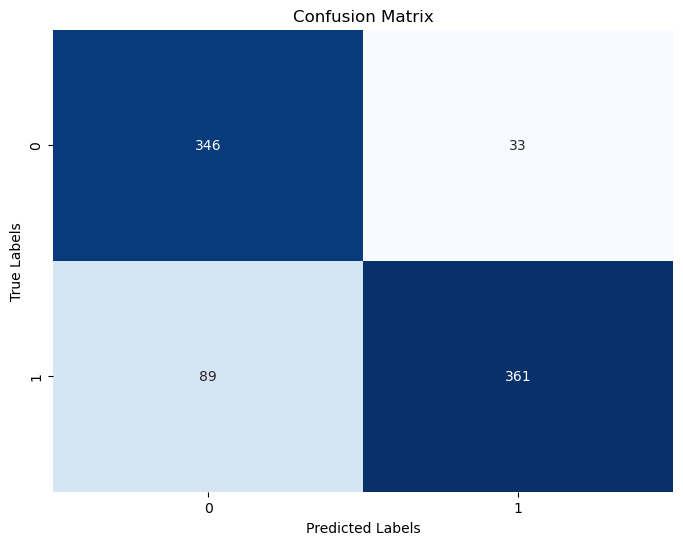

In [12]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()